# DeepFM建模

from google.colab import drive
drive.mount('/content/drive')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 加载数据

In [55]:
path = '/content/drive/Shareddrives/137074046的5T空间/competitions/tianchi_competitions/腾讯大数据多任务/wechat_algo_data/'

In [56]:
import joblib
train = joblib.load(path+'train.txt')
val = joblib.load(path+'val.txt')
test = joblib.load(path+'test.txt')
encoder = joblib.load(path+'encoder.txt')

train_num = len(train)

    path='/content/drive/Shareddrives/137074046的5T空间/competitions/tianchi_competitions/腾讯大数据多任务/wechat_algo_data/'

    joblib.dump(train, path+'train.txt')
    joblib.dump(val, path+'val.txt')
    joblib.dump(test, path+'test.txt')
    joblib.dump(encoder, path+'encoder.txt')

## 导入工具库

In [3]:
import numpy as np

import gc
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import *
from tensorflow.python.keras.layers import Layer
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

from tensorflow.keras import optimizers,initializers
from tensorflow.python.keras.initializers import glorot_normal

## 搭建DeepFM模型

In [4]:
class MeanPoolLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(MeanPoolLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, x, mask):
        mask = tf.expand_dims(tf.cast(mask,tf.float32),axis = -1)
        x = x * mask
        return K.sum(x, axis=self.axis) / (K.sum(mask, axis=self.axis) + 1e-9)

def secondary_fm(W):
    #先相加再平方。
    frs_part = Add()(W)
    frs_part = Multiply()([frs_part,frs_part]) 
    #先平方再相加
    scd_part = Add()([Multiply()([_x,_x]) for _x in W])
    #相减，乘0.5.
    fm_part = Subtract()([frs_part,scd_part])
    fm_part = Lambda(lambda x:K.sum(x,axis = 1,keepdims = True)*0.5,name='base_model_output_fm')(fm_part)
    return fm_part


def build_FM(sparse_cols,dense_cols,sparse_max_len,embed_dim = 16, 
               dnn_hidden_units=(128, 128),varlens_cols = [],varlens_max_len = {},
               dropout = 0,embedding_reg_l2 = 1e-6,dnn_reg_l2 = 0.0):
    ''' 
    sparse_cols,dense_cols:离散变量名，连续变量名。
    sparse_max_len：字典：离散变量对应的最大的取值范围。
    varlens_cols:可变离散变量名。
    varlens_max_len:可变离散变量的最大取值范围。
    '''
    
    #输入部分，分为sparse,varlens,dense部分。
    sparse_inputs = {f:Input([1],name = f) for f in sparse_cols}
    dense_inputs = {f:Input([1],name = f) for f in dense_cols}
    varlens_inputs = {f:Input([None,1],name = f) for f in varlens_cols}
        
    input_embed = {}
    #离散特征，embedding到k维，得到其隐向量。wi
    for f in sparse_cols:
        _input = sparse_inputs[f]
        embedding = Embedding(sparse_max_len[f], embed_dim, 
            embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg_l2)) 
        input_embed[f] =Flatten()(embedding(_input)) #(bs,k)
        
    #多标签离散变量 多标签离散变量是用的这个，masking掉了
    for f in varlens_inputs:
        _input = varlens_inputs[f]
        mask = Masking(mask_value = 0).compute_mask(_input)
        embedding = Embedding(varlens_max_len[f], embed_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        _embed =Reshape([-1,embed_dim])(embedding(_input))
        out_embed = MeanPoolLayer(axis=1)(_embed,mask) # 这里的输出也做了mask，是直接用的masking层做的
        input_embed[f] = out_embed
    
    #连续变量
    for f in dense_inputs:
        _input = dense_inputs[f]
        _embed = Dense(embed_dim,use_bias = False,activation = 'linear')(_input)
        input_embed[f] = _embed
        
    feature_name =  sparse_cols+varlens_cols+dense_cols
    fm_embed = [input_embed[f] for f in feature_name]
    fm_part = secondary_fm(fm_embed)
    
    #离散变量和连续变量拼接成dnn feature
    dnn_feature = Concatenate(axis = -1)(fm_embed)

    for index,num in enumerate(dnn_hidden_units):
        if index == len(dnn_hidden_units)-1:
          
          dnn_feature = Dropout(dropout,name='base_model_output_dnn')(Dense(num,activation='relu',
                      kernel_regularizer=regularizers.l2(dnn_reg_l2))(dnn_feature))
        else:
          dnn_feature = Dropout(dropout)(Dense(num,activation='relu',
                      kernel_regularizer=regularizers.l2(dnn_reg_l2))(dnn_feature))
        
        


    dnn_output = Dense(1,activation = 'linear', kernel_regularizer=regularizers.l2(dnn_reg_l2),
          use_bias = True)(dnn_feature)
    logits = Activation('sigmoid')(Add()([fm_part,dnn_output]))
    inputs = [sparse_inputs[f] for f in sparse_inputs]+[varlens_inputs[f] for f in varlens_inputs]\
                +[dense_inputs[f] for f in dense_inputs]
    model = Model(inputs,logits) 
    return model

In [6]:
# 特征与标签
target = ["read_comment", "like", "click_avatar", "forward"]
sparse_features = ['userid', 'feedid', 'authorid', 'bgm_song_id', 'bgm_singer_id']
varlen_features = ['manual_tag_list','manual_keyword_list']
dense_features = ['videoplayseconds']

# 生成输入特征设置
sparse_max_len = {f:len(encoder[f]) + 1 for f in sparse_features}
varlens_max_len = {f:len(encoder[f]) + 1 for f in varlen_features}
feature_names = sparse_features+varlen_features+dense_features

# 构建输入数据
## 用tf.data更好
train_model_input = {name: train[name] if name not in varlen_features else np.stack(train[name]) for name in feature_names } #训练模型的输入，字典类型。名称和具体值
val_model_input = {name: val[name] if name not in varlen_features else np.stack(val[name]) for name in feature_names }
test_model_input = {name: test[name] if name not in varlen_features else np.stack(test[name]) for name in feature_names}

train_labels = train['read_comment'].values
val_labels = val['read_comment'].values

# 多余的特征删除，释放内存
#del train,val 
gc.collect()





22

In [ ]:
model = build_FM(sparse_features,dense_features,sparse_max_len,embed_dim = 16, 
            dnn_hidden_units=(64,64),varlens_cols = varlen_features,varlens_max_len = varlens_max_len,
            dropout = 0.1,embedding_reg_l2 = 1e-6,dnn_reg_l2 = 0.0)
model.summary()

In [87]:
len(model.layers)

62

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [89]:
model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'activation_5')>

In [90]:
train_labels

array([1., 0., 0., ..., 0., 0., 0.])

In [91]:
model.layers.pop()

In [93]:
#len(model._layers)

In [94]:
del model.layers[-1]

In [ ]:
#model.get_output_at(3)

In [ ]:
dir(model)

In [ ]:
layers = model.layers
del layers[-1]
model.layers = layers

# 单任务结构

In [27]:
model = build_FM(sparse_features,dense_features,sparse_max_len,embed_dim = 16, 
            dnn_hidden_units=(64,64),varlens_cols = varlen_features,varlens_max_len = varlens_max_len,
            dropout = 0.1,embedding_reg_l2 = 1e-6,dnn_reg_l2 = 0.0)

In [28]:
adam = optimizers.Adam(learning_rate=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(adam, loss = 'binary_crossentropy' ,metrics = [tf.keras.metrics.AUC()],)

In [ ]:
from tensorflow.keras.callbacks import *
lr = ReduceLROnPlateau(monitor="val_auc_5", factor=0.75, 
                        patience=10, verbose=0)

es = EarlyStopping(monitor="val_auc_5", patience=15, 
                    verbose=2, mode="max", 
                    restore_best_weights=True)

history = model.fit(train_model_input, train['read_comment'].values,validation_data = (val_model_input,val['read_comment'].values),
                    batch_size=10240, epochs=200, verbose=1,callbacks=[lr,es])

    19033/19033 [==============================] - 78s 4ms/step - loss: 0.1024 - auc_5: 0.9258
    [0.1023578941822052, 0.925841212272644]

# 多任务结构设定(SB版)

多使用tensorflow的字典行为

In [203]:
deepfmcopy = tf.keras.models.clone_model(model) ##只clone结构不clone weights
deepfmcopy.set_weights(model.get_weights()) 
deepfmcopy.compile(adam, loss = 'binary_crossentropy' ,metrics = [tf.keras.metrics.AUC()],)

In [116]:
model.evaluate(val_model_input,val_labels)

19033/19033 [==============================] - 78s 4ms/step - loss: 0.1024 - auc_5: 0.9258


[0.1023578941822052, 0.925841212272644]

In [117]:
deepfmcopy.evaluate(val_model_input,val_labels)

19033/19033 [==============================] - 77s 4ms/step - loss: 0.1024 - auc_7: 0.9258


[0.1023578941822052, 0.925841212272644]

In [204]:
model.evaluate(val_model_input,val_labels)

19033/19033 [==============================] - 98s 5ms/step - loss: 0.1024 - auc_5: 0.9258


[0.1023578941822052, 0.925841212272644]

In [205]:
model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'activation_8')>

    deepfmcopy.get_layer('dense_33').output
    deepfmcopy.get_layer('base_model_output_dnn').output
    concates = tf.keras.layers.Concatenate([deepfmcopy.get_layer('dense_33').output,deepfmcopy.get_layer('base_model_output_dnn').output])

# 错误代码

In [7]:
class MeanPoolLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(MeanPoolLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, x, mask):
        mask = tf.expand_dims(tf.cast(mask,tf.float32),axis = -1)
        x = x * mask
        return K.sum(x, axis=self.axis) / (K.sum(mask, axis=self.axis) + 1e-9)

class MmoeLayer(tf.keras.layers.Layer):
    def __init__(self,n_expert,n_task,expert_dim):
        super(MmoeLayer, self).__init__()
        self.n_task = n_task
        self.expert_layer = [Dense(expert_dim,activation = 'relu') for i in range(n_expert)] ## 核心应该是改这里啊。。改expert的结构才有意义啊

        self.gate_layers = [Dense(n_expert,activation = 'softmax') for i in range(n_task)] # mmoe的结构，n个task对应n个gate
    
    def call(self,x):
        #多个专家网络
        E_net = [expert(x) for expert in self.expert_layer]
        E_net = Concatenate(axis = 1)([e[:,tf.newaxis,:] for e in E_net]) #(bs,n_expert,n_dims)
        #多个门网络
        gate_net = [gate(x) for gate in self.gate_layers]     #n_task个(bs,n_expert)
        
        #每个towers等于，对应的门网络乘上所有的专家网络。
        towers = []
        for i in range(self.n_task):
            g = tf.expand_dims(gate_net[i],axis = -1)  #(bs,n_expert,1)
            _tower = tf.matmul(E_net, g,transpose_a=True)
            towers.append(Flatten()(_tower))           #(bs,expert_dim)
            
        return towers ## 这里返回的towers可以进一步接其它layer


In [8]:
target = ["read_comment", "like", "click_avatar", "forward"]

train_labels = [train[y].values for y in target]
val_labels = [val[y].values for y in target]

使用单任务train好的结构在多任务上fine tune 貌似效果不是很好

In [9]:
model = build_FM(sparse_features,dense_features,sparse_max_len,embed_dim = 16, 
            dnn_hidden_units=(64,64),varlens_cols = varlen_features,varlens_max_len = varlens_max_len,
            dropout = 0.1,embedding_reg_l2 = 1e-6,dnn_reg_l2 = 0.0)

In [10]:
deepfmcopy = tf.keras.models.clone_model(model) ##只clone结构不clone weights
deepfmcopy.set_weights(model.get_weights()) 
#deepfmcopy.compile(adam, loss = 'binary_crossentropy' ,metrics = [tf.keras.metrics.AUC()],)

In [ ]:
deepfmcopy.summary()

In [17]:
from tensorflow.keras.optimizers import Adam 
adam = Adam(learning_rate=0.02, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [18]:
Inputs = deepfmcopy.input ## 

deepfm_layer_output = tf.keras.layers.Concatenate()([deepfmcopy.get_layer('dense_2').output,deepfmcopy.get_layer('base_model_output_dnn').output])
#mmoe网络层
towers = MmoeLayer(expert_dim=256,n_expert=8,n_task=4)(deepfm_layer_output) ## input embedd这个部分用mmoe就可以了
outputs = [Dense(1,activation='sigmoid')(output) for output in towers]
deepfm_mmoe = Model(Inputs,outputs)

deepfm_mmoe.compile(adam, loss = 'binary_crossentropy' ,metrics = [tf.keras.metrics.AUC()],) ## 这种本身就有复制结构和weights的效果


In [ ]:
deepfm_mmoe.summary()

In [ ]:
from tensorflow.keras.callbacks import *
lr = ReduceLROnPlateau(monitor="val_dense_16_auc_1", factor=0.75, 
                        patience=10, verbose=0)

es = EarlyStopping(monitor="val_dense_16_auc_1", patience=30, 
                    verbose=2, mode="max", 
                    restore_best_weights=True)

history = deepfm_mmoe.fit(train_model_input, train_labels,validation_data = (val_model_input,val_labels),
                    batch_size=10240, epochs=200, verbose=1,callbacks=[lr,es])

In [21]:
deepfm_mmoe.evaluate(val_model_input,val_labels)

19033/19033 [==============================] - 139s 7ms/step - loss: 0.2494 - dense_16_loss: 0.0923 - dense_17_loss: 0.0890 - dense_18_loss: 0.0364 - dense_19_loss: 0.0183 - dense_16_auc_1: 0.9256 - dense_17_auc_1: 0.8342 - dense_18_auc_1: 0.8172 - dense_19_auc_1: 0.8260


[0.24936777353286743,
 0.09227626025676727,
 0.088957279920578,
 0.03638340160250664,
 0.018305817618966103,
 0.9256324768066406,
 0.8342156410217285,
 0.8172459602355957,
 0.8260396718978882]

In [ ]:
deepfmcopy.evaluate(val_model_input,val_labels)

In [221]:
deepfmcopy.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'activation_8')>

In [219]:
deepfm_mmoe.output

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_256')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_257')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_258')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_259')>]

In [218]:
deepfm_mmoe.weights[0]

<tf.Variable 'embedding_61/embeddings:0' shape=(350, 16) dtype=float32, numpy=
array([[ 1.6327219e-31, -2.1161597e-31,  3.1145781e-33, ...,
         1.4693598e-31, -1.5728962e-31,  9.1310638e-32],
       [-1.5325925e-03, -1.7420399e-01, -1.9339371e-02, ...,
         1.1611331e-01,  1.7026336e-01,  4.2245224e-02],
       [-1.4212283e-01, -9.1626585e-02, -5.4865982e-02, ...,
         3.4505045e-01,  3.6639619e-01,  2.9734237e-02],
       ...,
       [-9.1455524e-07, -9.8016208e-06, -2.8080400e-05, ...,
         3.9035240e-06, -7.0932820e-06, -8.3940240e-06],
       [-5.4890079e-06,  3.5571105e-05,  5.8569354e-03, ...,
        -6.5455515e-06,  2.4107765e-05, -1.2782648e-03],
       [ 1.2475632e-31,  5.1268857e-32, -9.5355961e-32, ...,
         7.6548192e-35,  9.5778880e-32, -1.0207183e-31]], dtype=float32)>

In [ ]:
deepfm_mmoe.evaluate(val_model_input,val_labels)

In [191]:
preds

array([[0.15593019],
       [0.0761647 ],
       [0.12393709],
       ...,
       [0.0924482 ],
       [0.0803355 ],
       [0.1180457 ]], dtype=float32)

# 纯mmoe，没有backbone(expert的数量不是越多越好)

In [57]:
def build_mmoe(sparse_cols,dense_cols,sparse_max_len,embed_dim,expert_dim,
              varlens_cols,varlens_max_len,n_expert,n_task,target = [],
              dnn_hidden_units = (64,),dnn_reg_l2 = 1e-5,drop_rate = 0.1,
                embedding_reg_l2 = 1e-6):
    
    
    #输入部分，分为sparse,varlens,dense部分。
    sparse_inputs = {f:Input([1],name = f) for f in sparse_cols}
    dense_inputs = {f:Input([1],name = f) for f in dense_cols}
    varlens_inputs = {f:Input([None,1],name = f) for f in varlens_cols}
        
    input_embed = {}
    #离散特征，embedding到k维
    for f in sparse_cols:
        _input = sparse_inputs[f]
        embedding = Embedding(sparse_max_len[f], embed_dim, 
            embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg_l2)) 
        input_embed[f] =Flatten()(embedding(_input)) #(bs,k)
        
    #多标签离散变量
    for f in varlens_inputs:
        _input = varlens_inputs[f]
        mask = Masking(mask_value = 0).compute_mask(_input)
        embedding = Embedding(varlens_max_len[f], embed_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        _embed =Reshape([-1,embed_dim])(embedding(_input))
        out_embed = MeanPoolLayer(axis=1)(_embed,mask)
        input_embed[f] = out_embed
        
    input_embed.update(dense_inputs) #加入连续变量
    input_embed = Concatenate(axis = -1)([input_embed[f] for f in input_embed])

    ####################################################################################################### 应该修改的backbone在这个地方
    for num in dnn_hidden_units:
        input_embed = Dropout(drop_rate)(Dense(num,activation = 'relu',
                    kernel_regularizer=regularizers.l2(dnn_reg_l2))(input_embed))
    ########################################################################################################    
        ## 前面就是很简单的ffn的backbone
    
    #mmoe网络层
    towers = MmoeLayer(expert_dim,n_expert,n_task)(input_embed) ## input embedd这个部分用mmoe就可以了
    ## 是直接用mmoe的layer代替了deepfm的layer来做的，wtf

    outputs = [Dense(1,activation = 'sigmoid', kernel_regularizer=regularizers.l2(dnn_reg_l2),
                     name = f,use_bias = True)(_t) for _t,f in zip(towers,target)]
    inputs = [sparse_inputs[f] for f in sparse_inputs]+[varlens_inputs[f] for f in varlens_inputs]\
                +[dense_inputs[f] for f in dense_inputs]
    model = Model(inputs,outputs) 
    return model

In [58]:
class MeanPoolLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(MeanPoolLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, x, mask):
        mask = tf.expand_dims(tf.cast(mask,tf.float32),axis = -1)
        x = x * mask
        return K.sum(x, axis=self.axis) / (K.sum(mask, axis=self.axis) + 1e-9)

class MmoeLayer(tf.keras.layers.Layer):
    def __init__(self,n_expert,n_task,expert_dim):
        super(MmoeLayer, self).__init__()
        self.n_task = n_task
        self.expert_layer = [Dense(expert_dim,activation = 'relu') for i in range(n_expert)] ## 核心应该是改这里啊。。改expert的结构才有意义啊

        self.gate_layers = [Dense(n_expert,activation = 'softmax') for i in range(n_task)] # mmoe的结构，n个task对应n个gate
    
    def call(self,x):
        #多个专家网络
        E_net = [expert(x) for expert in self.expert_layer]
        E_net = Concatenate(axis = 1)([e[:,tf.newaxis,:] for e in E_net]) #(bs,n_expert,n_dims)
        #多个门网络
        gate_net = [gate(x) for gate in self.gate_layers]     #n_task个(bs,n_expert)
        
        #每个towers等于，对应的门网络乘上所有的专家网络。
        towers = []
        for i in range(self.n_task):
            g = tf.expand_dims(gate_net[i],axis = -1)  #(bs,n_expert,1)
            _tower = tf.matmul(E_net, g,transpose_a=True)
            towers.append(Flatten()(_tower))           #(bs,expert_dim)
            
        return towers ## 这里返回的towers可以进一步接其它layer


In [61]:
from tensorflow.keras.callbacks import *
lr = ReduceLROnPlateau(monitor="val_read_comment_auc_9", factor=0.75, 
                        patience=10, verbose=0)

es = EarlyStopping(monitor="val_read_comment_auc_9", patience=30, 
                    verbose=2, mode="max", 
                    restore_best_weights=True)

In [62]:
# 构建模型，训练和评估
model = build_mmoe(sparse_features,dense_features,sparse_max_len,embed_dim = 16,expert_dim = 32,
          n_task = 4,n_expert = 4,varlens_cols = varlen_features,varlens_max_len = varlens_max_len,
          dnn_hidden_units = (64,64),target = target,dnn_reg_l2 = 1e-5,drop_rate = 0.1)


adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(adam, loss = 'binary_crossentropy' ,metrics = [tf.keras.metrics.AUC()],)

history = model.fit(train_model_input, train_labels,validation_data = (val_model_input,val_labels),
                    batch_size=10240, epochs=100, verbose=1,callbacks=[lr,es])

Epoch 1/100
656/656 [==============================] - 20s 21ms/step - loss: 0.3100 - read_comment_loss: 0.1113 - like_loss: 0.1062 - click_avatar_loss: 0.0496 - forward_loss: 0.0301 - read_comment_auc_9: 0.8951 - like_auc_9: 0.7961 - click_avatar_auc_9: 0.7244 - forward_auc_9: 0.6893 - val_loss: 0.2569 - val_read_comment_loss: 0.0944 - val_like_loss: 0.0909 - val_click_avatar_loss: 0.0372 - val_forward_loss: 0.0195 - val_read_comment_auc_9: 0.9172 - val_like_auc_9: 0.8249 - val_click_avatar_auc_9: 0.8030 - val_forward_auc_9: 0.7732 - lr: 0.0100
Epoch 2/100
656/656 [==============================] - 13s 19ms/step - loss: 0.2547 - read_comment_loss: 0.0914 - like_loss: 0.0906 - click_avatar_loss: 0.0361 - forward_loss: 0.0205 - read_comment_auc_9: 0.9324 - like_auc_9: 0.8548 - click_avatar_auc_9: 0.8322 - forward_auc_9: 0.8189 - val_loss: 0.2550 - val_read_comment_loss: 0.0936 - val_like_loss: 0.0904 - val_click_avatar_loss: 0.0367 - val_forward_loss: 0.0189 - val_read_comment_auc_9: 0.

In [ ]:
# 构建模型，训练和评估
model = build_mmoe(sparse_features,dense_features,sparse_max_len,embed_dim = 16,expert_dim = 32,
          n_task = 4,n_expert = 4,varlens_cols = varlen_features,varlens_max_len = varlens_max_len,
          dnn_hidden_units = (64,64),target = target,dnn_reg_l2 = 1e-5,drop_rate = 0.1)


adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(adam, loss = 'binary_crossentropy' ,metrics = [tf.keras.metrics.AUC()],)

history = model.fit(train_model_input, train_labels,validation_data = (val_model_input,val_labels),
                    batch_size=10240, epochs=100, verbose=1,callbacks=[lr,es])

    read_comment_auc_5: 0.9607

# 在deepfm后面接mmoe

In [43]:
def build_FM_mmoe(sparse_cols,dense_cols,sparse_max_len,embed_dim = 16, 
               dnn_hidden_units=(128, 128),varlens_cols = [],varlens_max_len = {},
               dropout = 0,embedding_reg_l2 = 1e-6,dnn_reg_l2 = 0.0):
    ''' 
    sparse_cols,dense_cols:离散变量名，连续变量名。
    sparse_max_len：字典：离散变量对应的最大的取值范围。
    varlens_cols:可变离散变量名。
    varlens_max_len:可变离散变量的最大取值范围。
    '''
    
    #输入部分，分为sparse,varlens,dense部分。
    sparse_inputs = {f:Input([1],name = f) for f in sparse_cols}
    dense_inputs = {f:Input([1],name = f) for f in dense_cols}
    varlens_inputs = {f:Input([None,1],name = f) for f in varlens_cols}
        
    input_embed = {}
    #离散特征，embedding到k维，得到其隐向量。wi
    for f in sparse_cols:
        _input = sparse_inputs[f]
        embedding = Embedding(sparse_max_len[f], embed_dim, 
            embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg_l2)) 
        input_embed[f] =Flatten()(embedding(_input)) #(bs,k)
        
    #多标签离散变量 多标签离散变量是用的这个，masking掉了
    for f in varlens_inputs:
        _input = varlens_inputs[f]
        mask = Masking(mask_value = 0).compute_mask(_input)
        embedding = Embedding(varlens_max_len[f], embed_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        _embed =Reshape([-1,embed_dim])(embedding(_input))
        out_embed = MeanPoolLayer(axis=1)(_embed,mask) # 这里的输出也做了mask，是直接用的masking层做的
        input_embed[f] = out_embed
    
    #连续变量
    for f in dense_inputs:
        _input = dense_inputs[f]
        _embed = Dense(embed_dim,use_bias = False,activation = 'linear')(_input)
        input_embed[f] = _embed
        
    feature_name =  sparse_cols+varlens_cols+dense_cols
    fm_embed = [input_embed[f] for f in feature_name]
    fm_part = secondary_fm(fm_embed)
    
    #离散变量和连续变量拼接成dnn feature
    dnn_feature = Concatenate(axis = -1)(fm_embed)

    for index,num in enumerate(dnn_hidden_units):
        if index == len(dnn_hidden_units)-1:
          
          dnn_feature = Dropout(dropout,name='base_model_output_dnn')(Dense(num,activation='relu',
                      kernel_regularizer=regularizers.l2(dnn_reg_l2))(dnn_feature))
        else:
          dnn_feature = Dropout(dropout)(Dense(num,activation='relu',
                      kernel_regularizer=regularizers.l2(dnn_reg_l2))(dnn_feature))
        
        


    deepfm_output =Concatenate()([fm_part,dnn_feature])
    towers = MmoeLayer(32,4,4)(deepfm_output) ## input embedd这个部分用mmoe就可以了
    outputs = [Dense(1,activation = 'sigmoid', kernel_regularizer=regularizers.l2(dnn_reg_l2),
                     name = f,use_bias = True)(_t) for _t,f in zip(towers,target)]
    
    inputs = [sparse_inputs[f] for f in sparse_inputs]+[varlens_inputs[f] for f in varlens_inputs]\
                +[dense_inputs[f] for f in dense_inputs]
    model = Model(inputs,outputs) 
    return model

In [52]:
model = build_FM_mmoe(sparse_features,dense_features,sparse_max_len,embed_dim = 16, 
            dnn_hidden_units=(64,64),varlens_cols = varlen_features,varlens_max_len = varlens_max_len,
            dropout = 0.1,embedding_reg_l2 = 1e-6,dnn_reg_l2 = 0.0)

In [53]:
adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(adam, loss = 'binary_crossentropy' ,metrics = [tf.keras.metrics.AUC()],)

In [ ]:
from tensorflow.keras.callbacks import *
lr = ReduceLROnPlateau(monitor="val_read_comment_auc_7", factor=0.75, 
                        patience=10, verbose=0)

es = EarlyStopping(monitor="val_read_comment_auc_7", patience=30, 
                    verbose=2, mode="max", 
                    restore_best_weights=True)

history = model.fit(train_model_input, train_labels,validation_data = (val_model_input,val_labels),
                    batch_size=10240, epochs=200, verbose=1,callbacks=[lr,es])

read_comment_auc_7: 0.9534 

# 腾讯PLE

In [64]:
class MeanPoolLayer(Layer):
    def __init__(self, axis, **kwargs):
        super(MeanPoolLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, x, mask):
        mask = tf.expand_dims(tf.cast(mask,tf.float32),axis = -1)
        x = x * mask
        return K.sum(x, axis=self.axis) / (K.sum(mask, axis=self.axis) + 1e-9)

class PleLayer(tf.keras.layers.Layer):
    '''
    n_experts:list,每个任务使用几个expert。[2,3]第一个任务使用2个expert，第二个任务使用3个expert。
    n_expert_share:int,共享的部分设置的expert个数。
    expert_dim:int,每个专家网络输出的向量维度。
    n_task:int,任务个数。
    '''
    def __init__(self,n_task,n_experts,expert_dim,n_expert_share,dnn_reg_l2 = 1e-5):
        super(PleLayer, self).__init__()
        self.n_task = n_task
        
        # 生成多个任务特定网络和1个共享网络。
        self.E_layer = []
        for i in range(n_task):
            sub_exp = [Dense(expert_dim,activation = 'relu') for j in range(n_experts[i])]
            self.E_layer.append(sub_exp)
            
        self.share_layer = [Dense(expert_dim,activation = 'relu') for j in range(n_expert_share)]
        #定义门控网络
        self.gate_layers = [Dense(n_expert_share+n_experts[i],kernel_regularizer=regularizers.l2(dnn_reg_l2),
                                  activation = 'softmax') for i in range(n_task)]

    def call(self,x):
        #特定网络和共享网络
        E_net = [[expert(x) for expert in sub_expert] for sub_expert in self.E_layer]
        share_net = [expert(x) for expert in self.share_layer]
        
        #门的权重乘上，指定任务和共享任务的输出。
        towers = []
        for i in range(self.n_task):
            g = self.gate_layers[i](x)
            g = tf.expand_dims(g,axis = -1) #(bs,n_expert_share+n_experts[i],1)
            _e = share_net+E_net[i]  
            _e = Concatenate(axis = 1)([expert[:,tf.newaxis,:] for expert in _e]) #(bs,n_expert_share+n_experts[i],expert_dim)
            _tower = tf.matmul(_e, g,transpose_a=True)
            towers.append(Flatten()(_tower)) #(bs,expert_dim)
        return towers

def build_ple(sparse_cols,dense_cols,sparse_max_len,embed_dim,expert_dim = 4,
              varlens_cols = [],varlens_max_len = [],dnn_hidden_units = (64,64),
              n_task = 2,n_experts = [2,2],n_expert_share = 4,dnn_reg_l2 = 1e-6,
              drop_rate = 0.0,embedding_reg_l2 = 1e-6,targets = []):

   #输入部分，分为sparse,varlens,dense部分。
    sparse_inputs = {f:Input([1],name = f) for f in sparse_cols}
    dense_inputs = {f:Input([1],name = f) for f in dense_cols}
    varlens_inputs = {f:Input([None,1],name = f) for f in varlens_cols}
        
    input_embed = {}
    #离散特征，embedding到k维
    for f in sparse_cols:
        _input = sparse_inputs[f]
        embedding = Embedding(sparse_max_len[f], embed_dim, 
            embeddings_regularizer=tf.keras.regularizers.l2(embedding_reg_l2)) 
        input_embed[f] =Flatten()(embedding(_input)) #(bs,k)
        
    #多标签离散变量
    for f in varlens_inputs:
        _input = varlens_inputs[f]
        mask = Masking(mask_value = 0).compute_mask(_input)
        embedding = Embedding(varlens_max_len[f], embed_dim,
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6))
        _embed =Reshape([-1,embed_dim])(embedding(_input))
        out_embed = MeanPoolLayer(axis=1)(_embed,mask)
        input_embed[f] = out_embed
        
    input_embed.update(dense_inputs) #加入连续变量
    input_embed = Concatenate(axis = -1)([input_embed[f] for f in input_embed])    
                                  
    for num in dnn_hidden_units:
        input_embed = Dropout(drop_rate)(Dense(num,activation = 'relu',
                    kernel_regularizer=regularizers.l2(dnn_reg_l2))(input_embed))
    #Ple网络层
    towers = PleLayer(n_task,n_experts,expert_dim,n_expert_share)(input_embed)
    outputs = [Dense(1,activation = 'sigmoid',kernel_regularizer=regularizers.l2(dnn_reg_l2),
                       name = f,use_bias = True)(_t) for f,_t in zip(targets,towers)]
    inputs = [sparse_inputs[f] for f in sparse_inputs]+[varlens_inputs[f] for f in varlens_inputs]\
                +[dense_inputs[f] for f in dense_inputs]
    model = Model(inputs,outputs) 
    return model

In [68]:
# 构建模型，训练和评估
model = build_ple(sparse_features,dense_features,sparse_max_len,embed_dim = 16,expert_dim = 32,
          varlens_cols = varlen_features,varlens_max_len = varlens_max_len,dnn_hidden_units = (64,),
          n_task = 4,n_experts = [8,4,4,4],n_expert_share = 8,dnn_reg_l2 = 1e-6,
          drop_rate = 0.1,embedding_reg_l2 = 1e-6,targets = target)

adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(adam, loss = 'binary_crossentropy' ,metrics = [tf.keras.metrics.AUC()],)


from tensorflow.keras.callbacks import *
lr = ReduceLROnPlateau(monitor="val_read_comment_auc_13", factor=0.75, 
                        patience=10, verbose=2,model='max')

es = EarlyStopping(monitor="val_read_comment_auc_13", patience=30, 
                    verbose=2, mode="max", 
                    restore_best_weights=True)

history = model.fit(train_model_input, train_labels,validation_data = (val_model_input,val_labels),
                    batch_size=10240, epochs=200, verbose=1,callbacks=[lr,es])

Epoch 1/200
656/656 [==============================] - 21s 23ms/step - loss: 0.2828 - read_comment_loss: 0.1012 - like_loss: 0.0995 - click_avatar_loss: 0.0435 - forward_loss: 0.0261 - read_comment_auc_13: 0.9088 - like_auc_13: 0.8184 - click_avatar_auc_13: 0.7740 - forward_auc_13: 0.7574 - val_loss: 0.2529 - val_read_comment_loss: 0.0935 - val_like_loss: 0.0900 - val_click_avatar_loss: 0.0364 - val_forward_loss: 0.0186 - val_read_comment_auc_13: 0.9213 - val_like_auc_13: 0.8306 - val_click_avatar_auc_13: 0.8207 - val_forward_auc_13: 0.8143 - lr: 0.0100
Epoch 2/200
656/656 [==============================] - 14s 21ms/step - loss: 0.2492 - read_comment_loss: 0.0899 - like_loss: 0.0892 - click_avatar_loss: 0.0351 - forward_loss: 0.0194 - read_comment_auc_13: 0.9358 - like_auc_13: 0.8628 - click_avatar_auc_13: 0.8484 - forward_auc_13: 0.8525 - val_loss: 0.2518 - val_read_comment_loss: 0.0927 - val_like_loss: 0.0893 - val_click_avatar_loss: 0.0362 - val_forward_loss: 0.0183 - val_read_comme

# others

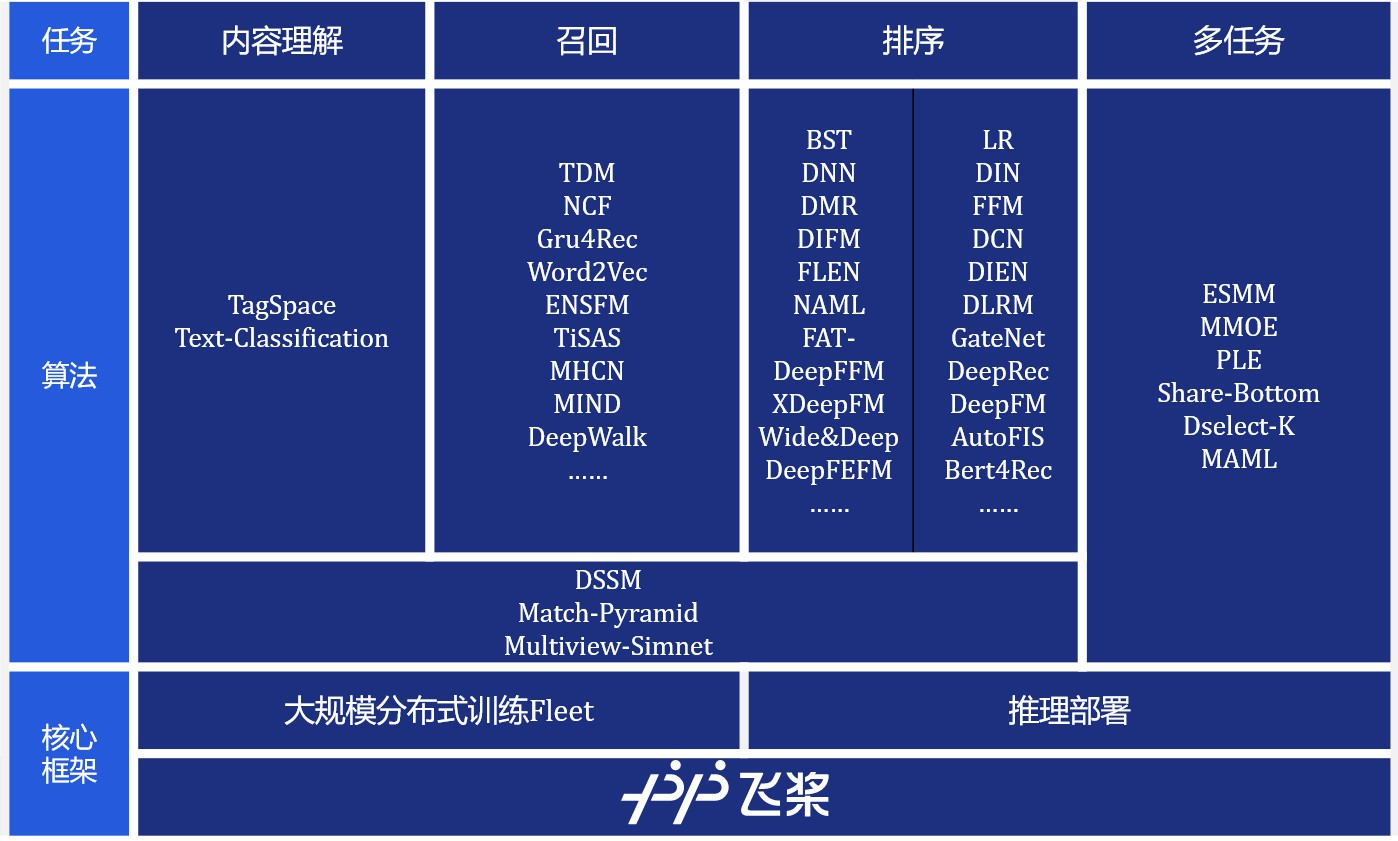

https://github.com/ShowMeAI-Hub/multi-task-learning

https://github.com/shenweichen/DeepCTR

https://github.com/ShowMeAI-Hub/ctr-prediction

https://github.com/busesese/ESMM/blob/master/esmm.py

https://m-clark.github.io/posts/2021-07-15-dl-for-tabular/

# auc 优化

In [ ]:
https://zhuanlan.zhihu.com/p/388262192?utm_source=wechat_session&utm_medium=social&utm_oi=29889247838208&utm_campaign=shareopn

https://zhuanlan.zhihu.com/p/74216219

https://towardsdatascience.com/explicit-auc-maximization-70beef6db14e

https://www.kaggle.com/code/tomcwalker/keras-nn-with-custom-loss-function-for-gini-auc/notebook

# pytorch lightning 魔改 torch的各种tabular nn

In [ ]:
https://www.kaggle.com/code/gautham11/quantile-regression-pytorch-lightning-inference/notebook

# 降低 embedding的参数量级

In [ ]:
https://keras.io/examples/keras_recipes/memory_efficient_embeddings/

In [ ]:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Hashing